In [4]:
%run notebook_utils.py

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%cd ..
from langid import WrappedVectorizer, sanitize, np_sanitize
%cd - 

/Users/Lin/git/SwigSpot/language-detection
/Users/Lin/git/SwigSpot/language-detection/notebooks


In [52]:
# set big font in plots
SMALL_SIZE = 18
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

In [6]:
# load data
X_train, X_test, y_train, y_test = load_split_data()
sms_any_X, sms_any_y = load_sms_any()
X_valid, y_valid = load_validation_data()

In [7]:
# sanitize once 
X_train = np_sanitize(X_train)
X_test = np_sanitize(X_test)
sms_any_X = np_sanitize(sms_any_X)
X_valid = np_sanitize(X_valid)

# Number of features

In [9]:
import sklearn.metrics
import numpy as np

feature_sizes = [500, 700, 1000, 3000, 5000, 7000, 10000] 

accuracies = []
f1_scores = []
precisions = []
recalls = []

labels = [None] + [[i] for i in range(len(langs))]
pipes = []

vec_params = dict(analyzer='char', ngram_range=(3,3), smooth_idf=True, use_idf=True)

for feats in feature_sizes:
    pipe = Pipeline(steps=[
        ('vec', TfidfVectorizer(**vec_params, max_features=feats)),
        ('clf', LogisticRegression())
    ])
    pipe.fit(X_train, y_train)
    pipes.append(pipe)
    
    y_pred = pipe.predict(X_test)
    
    accuracies.append(metrics.accuracy_score(y_test, y_pred))
    f1_scores.append([ metrics.f1_score(y_test, y_pred, average="macro", labels=i) for i in labels ])    
    precisions.append([ metrics.precision_score(y_test, y_pred, average="macro", labels=i) for i in labels ])
    recalls.append([ metrics.recall_score(y_test, y_pred, average="macro", labels=i) for i in labels ])

In [10]:
f1s = np.array(f1_scores)
precs = np.array(precisions)
recs = np.array(recalls)

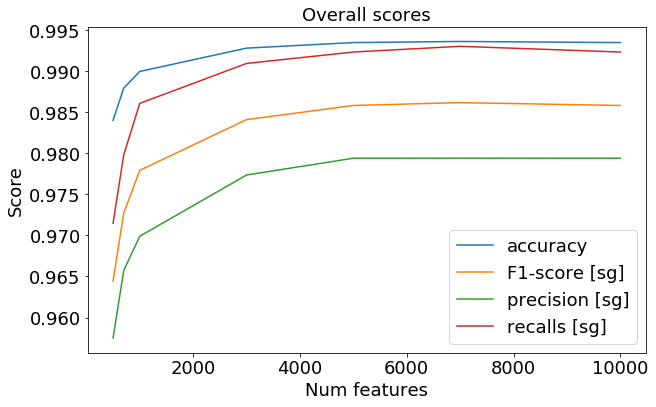

In [53]:
plt.figure(figsize=(10,6))

lg = 5
plt.plot(feature_sizes, accuracies, label="accuracy")
plt.plot(feature_sizes, f1s[:,lg], label="F1-score [sg]")
plt.plot(feature_sizes, precs[:,lg], label="precision [sg]")
plt.plot(feature_sizes, recs[:,lg], label="recalls [sg]")

plt.title("Overall scores")
plt.xlabel("Num features")
plt.ylabel("Score")

_ = plt.legend()

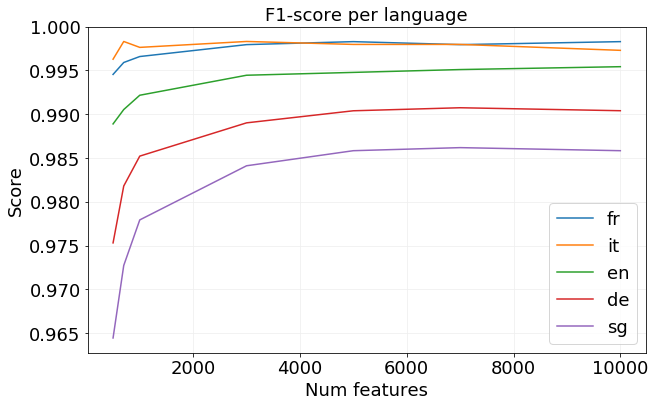

In [54]:
plt.figure(figsize=(10,6))

#plt.plot(feature_sizes, f1s[:,0], label="F1-score")
for i in [2,4,3,1,5]:
    plt.plot(feature_sizes, f1s[:,i], label=langs[i-1])
    #plt.plot(feature_sizes, precs[:,lg], label="precision [%s]" % langs[i-1])

plt.grid(c="#efefef")
plt.xlabel("Num features")
plt.ylabel("Score")
plt.title("F1-score per language")
_ = plt.legend()

# Probabilities: using different min_proba thresholds (6000 features)

In [ ]:
pipe = Pipeline(steps=[
    ('vec', TfidfVectorizer(**vec_params, max_features=6000)),
    ('clf', LogisticRegression())
])
_ = pipe.fit(X_train, y_train)

In [44]:
thresholds = [.5, .7, .8, .85, .9, .95]

def get_metrics_for_thresholds(X, y):
    bin_accs = []
    bin_recs = []
    bin_precs = []
    
    y_pred_proba = pipe.predict_proba(X)
    y_bin = np.array(y == 4, dtype=int)

    for min_proba in thresholds:
        y_bin_pred = np.array(y_pred_proba[:,4] >= min_proba, dtype=int)
        bin_accs.append(metrics.accuracy_score(y_bin, y_bin_pred))
        bin_precs.append(metrics.precision_score(y_bin, y_bin_pred))
        bin_recs.append(metrics.recall_score(y_bin, y_bin_pred))
        
    return bin_accs, bin_recs, bin_precs

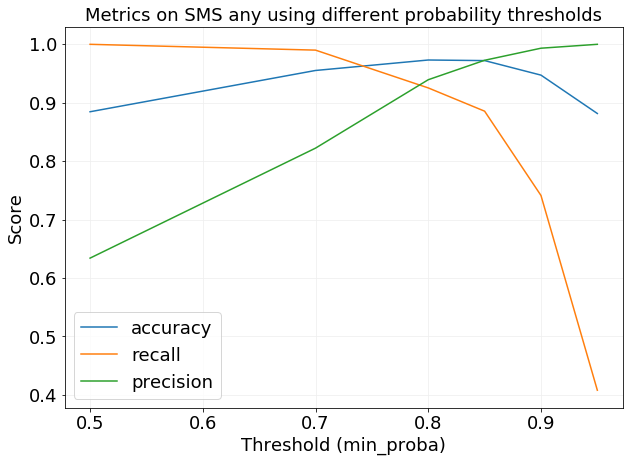

In [57]:
bin_accs, bin_recs, bin_precs = get_metrics_for_thresholds(sms_any_X, sms_any_y)

plt.figure(figsize=(10,7))

#plt.plot(feature_sizes, f1s[:,0], label="F1-score")
for (label, data) in [('accuracy', bin_accs), ('recall', bin_recs), ('precision', bin_precs)]:
    plt.plot(thresholds, data, label=label)
    #plt.plot(feature_sizes, precs[:,lg], label="precision [%s]" % langs[i-1])

plt.grid(c="#efefef")
plt.xlabel("Threshold (min_proba)")
plt.ylabel("Score")
plt.title("Metrics on SMS any using different probability thresholds")
_ = plt.legend()

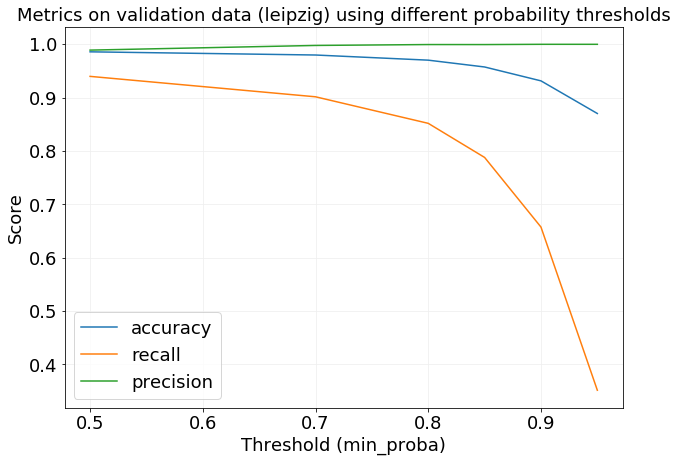

In [58]:
bin_accs, bin_recs, bin_precs = get_metrics_for_thresholds(X_valid, y_valid)

plt.figure(figsize=(10,7))

#plt.plot(feature_sizes, f1s[:,0], label="F1-score")
for (label, data) in [('accuracy', bin_accs), ('recall', bin_recs), ('precision', bin_precs)]:
    plt.plot(thresholds, data, label=label)
    #plt.plot(feature_sizes, precs[:,lg], label="precision [%s]" % langs[i-1])

plt.grid(c="#efefef")
plt.xlabel("Threshold (min_proba)")
plt.ylabel("Score")
plt.title("Metrics on validation data (leipzig) using different probability thresholds")
_ = plt.legend()

## ROC curve (SG - non-SG)

best proba: 0.70


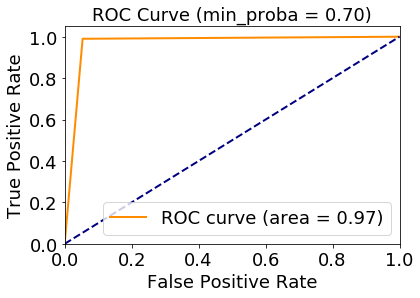

In [136]:
min_proba = .8

X, y = sms_any_X, sms_any_y  #X_valid, y_valid # X_test, y_test  
y_pred_proba = pipe.predict_proba(X)
y_bin = np.array(y == 4, dtype=int)

best_proba = None
best_auc = 0

for min_proba in thresholds:
    y_bin_pred = np.array(y_pred_proba[:,4] >= min_proba, dtype=int)
    fpr, tpr, _ = metrics.roc_curve(y_bin, y_bin_pred)
    roc_auc = metrics.auc(fpr, tpr)
    if roc_auc >= best_auc:
        best_auc = roc_auc
        best_proba = min_proba

print("best proba: %.2f" % best_proba)
y_bin_pred = np.array(y_pred_proba[:,4] >= best_proba, dtype=int)
fpr, tpr, _ = metrics.roc_curve(y_bin, y_bin_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (min_proba = %.2f)' % best_proba)
plt.legend(loc="lower right")
plt.show()